## Autoregressive Models

An autoregressive model works on sequential data, learning the probability of the next token given the previous tokens. Mathematically, we can say that the autoregressive model is trying to find the probability distribution $p(x_t|x_{t-1}, x_{t-2},...,x_{0})$ where $x_t$ is the token at timestep $t$. Autoregressive models are therefore well-suited for predicting text. For example, given the sentence

>no use crying over spilled _

an autoregressive model should assign a high probability that "milk" is the next word and assign a lower probability that "water" is the next word.

However, autoregressive models can also be applied to images. A popular example of this is [PixelCNN](https://arxiv.org/abs/1601.06759). The model works by treating an image as a sequence of pixels and then generating new images one pixel at a time, conditioned on all pixels generated already. This notebook implements a simple PixelCNN model using the MNIST dataset and explains each step.

In [51]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

## Model

Key to PixelCNN's success is the Masked Convolutional Layer. This essentially works in the same way as a normal convolution, except that all elements after the center value (meaning all elements below or to the right and in line with the center value) are set to zero. This is done by element-wise multiplying a mask full of 1's and 0's, as seen in the plot below. This means that convolutions can only make use of pixels above and to the left of a given center pixel.

In [52]:
class MaskedConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, mask_type):
        super().__init__()
        # Save which type of MaskedConvLayer we are using: 'A' or 'B'
        self.mask_type = mask_type

        # Create a normal convolution layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)

        # Create a binary mask that will be applied to the weights of the conv layer
        kernel_shape = self.conv.weight.shape
        self.mask = torch.zeros(kernel_shape)
        self.mask[:, :, :kernel_shape[2] // 2, :] = 1.0
        self.mask[:, :, kernel_shape[2] // 2, :kernel_shape[3] // 2] = 1.0
        if self.mask_type == "B":
            self.mask[:, :, kernel_shape[2] // 2, kernel_shape[3] // 2] = 1.0

    def forward(self, image):
        # Mask out the weights
        device = next(self.parameters()).device
        self.conv.weight.data = self.conv.weight * self.mask.to(device)

        # Run image through the convolution layer
        return self.conv(image)

There are two types of masks used in a masked convolution layer: type A and type B. In type A, the center pixel is not masked, whereas in type B, the center pixel is masked. Type A will be used at the start of the network. The center pixel is set to zeros because that is the pixel we want to predict. However, after the first layer, we no longer need to mask out the middle pixel because we have already restricted the prediction to not include the center pixel's original value. Therefore the rest of the network uses type B masked convolution layer.

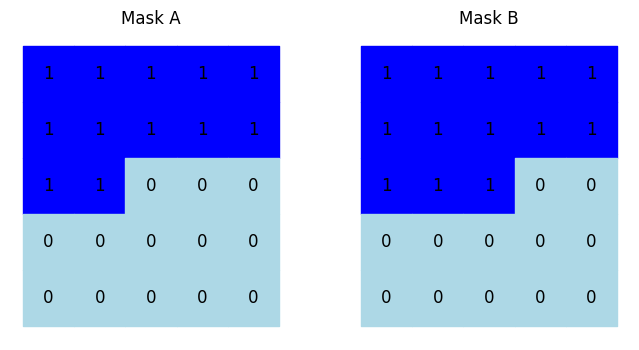

In [53]:
# Create Masked Convolutional Layers of both types
mask_size = 5
masked_conv_A = MaskedConvLayer(1, 16, mask_size, 1, 'A')
masked_conv_B = MaskedConvLayer(1, 16, mask_size, 1, 'B')
masked_conv_layers = [masked_conv_A, masked_conv_B]

# Plot the masks used in these convolutional layers
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for layer_idx, masked_layer in enumerate(masked_conv_layers):
    for i in range(mask_size):
        for j in range(mask_size):
            cell_value = masked_layer.mask[0, 0, i, j].item()
            ax[layer_idx].text(j + 0.5, mask_size - i - 0.5, str(int(cell_value)), ha='center', va='center', fontsize=12, color='black' if cell_value == 0 else 'black')
            ax[layer_idx].fill_between([j, j + 1], mask_size - i - 1, mask_size - i, color='lightblue' if cell_value == 0 else 'blue')
    ax[layer_idx].axis('off')
    ax[layer_idx].set_title('Mask ' + masked_layer.mask_type)



Next, we create a Residual Block. This module includes convolutional layers and also adds the original input to the final output. This structure solves the vanishing and exploding gradients problem and allows for the creation of deeper (and therefore more powerful) neural networks.

In [54]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        # Create a residual block with a masked convolution in the middle
        middle_channels = channels // 2
        self.res_block = nn.Sequential(
            nn.Conv2d(channels, middle_channels, 1),
            nn.ReLU(),
            MaskedConvLayer(middle_channels, middle_channels, 3, 1, 'B'),
            nn.ReLU(),
            nn.Conv2d(middle_channels, channels, 1),
            nn.ReLU(),
        )

    def forward(self, input):
        # Pass image though convolutional layers
        x = self.res_block(input)

        # Elementwise addition of input to the result
        return x + input

Finally, we create the overall PixelCNN architecture. This is a relatively simple combination of masked convolution layers and residual blocks, with ReLUs used for activations. To enhance the quality of the images produced, we also include an embedding layer with 10 options, one for each digit. This allows us to specify which digit we want.

In [55]:
class PixelCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Embedding layer with possible 10 embeddings, which are all vectors of length 784
        self.embedding = nn.Embedding(10, 784)

        # Initial convolution layer
        self.res_block = nn.Sequential(
            MaskedConvLayer(in_channels, out_channels, 7, 1, 'A'),
            nn.ReLU(),
        )

        # Residual layers
        r_layers = []
        for i in range(6):
            r_layers.append(ResidualBlock(out_channels))
        self.residual_layers = nn.Sequential(*r_layers)

        # Add masked layers that act as dense layers
        d_layers = []
        for i in range(6):
            d_layers.append(MaskedConvLayer(out_channels, out_channels, 1, 1, 'B'))
            d_layers.append(nn.ReLU())
        self.dense_layers = nn.Sequential(*d_layers)

        # Final convolutional layer
        self.output_conv = nn.Sequential(
            nn.Dropout2d(0.5),
            MaskedConvLayer(out_channels, 4, 1, 1, 'B'),
            #nn.LogSoftmax(dim=1),
        )

    def forward(self, image, label):
        # Embedding
        emb = self.embedding(label)
        emb = torch.reshape(emb, image.shape)

        # Run input through PixelCNN layers
        x1 = self.res_block(image)
        x2 = self.residual_layers(x1 + emb)
        x3 = self.dense_layers(x2 + emb)
        x4 = self.output_conv(x3 + emb)
        return x4

## Data

In this example we will use the MNIST dataset, which contains 60000 training images and 10000 testing images of handwritten digits. Let's download and plot some examples from the training data.

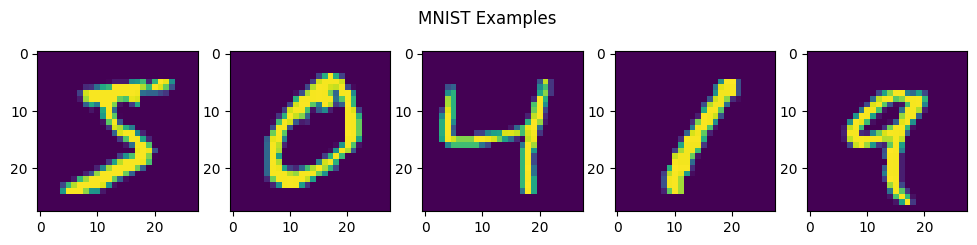

In [56]:
# Are we using the CPU or the GPU?
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transforms to be applied to all images in the dataset
tf = transforms.Compose(
    [transforms.ToTensor()]
)

# Download/setup the MNIST dataset
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('MNIST Examples')
ax[0].imshow(dataset[0][0][0,:,:].numpy())
ax[1].imshow(dataset[1][0][0,:,:].numpy())
ax[2].imshow(dataset[2][0][0,:,:].numpy())
ax[3].imshow(dataset[3][0][0,:,:].numpy())
ax[4].imshow(dataset[4][0][0,:,:].numpy())


## Training

You may have noticed that PixelCNN has 4 output channels, where as MNIST images only have 1 channel.  This is because we have designed to model to select 1 of 4 possible values.  This is implemented by quantizing the original MNIST images into 4 non-overlapping binary images as seen below.  The first images contains 1's where ever there are pixel values between 0 and 0.25 (and zeros everywhere else), the second images contains 1's where ever there are pixels between 0.25 and 0.5, and so on.

You may have noticed that PixelCNN has 4 output channels, whereas MNIST images only have 1 channel. This is because we have designed the model to select 1 of 4 possible values. This is implemented by quantizing the original MNIST images into 4 non-overlapping binary images, as seen below. The first image contains 1's wherever there are pixel values between 0 and 0.25 (and zeros everywhere else), the second image contains 1's wherever there are pixels between 0.25 and 0.5, and so on.

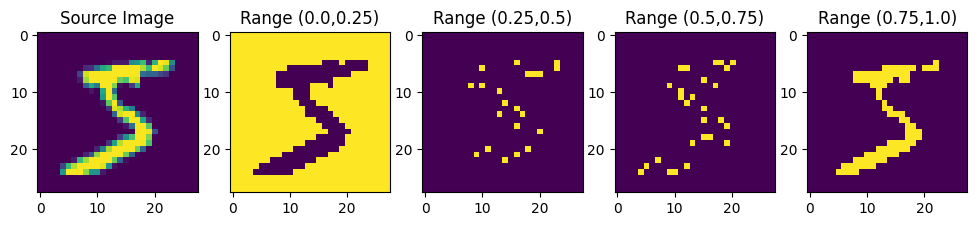

In [57]:
def binarize(img, min, max):
    # Set anything below the minimum threshold to 2
    img = torch.where(img < min, 2 * torch.ones_like(img), img)

    # Set anything above the max threshold to 0, set everything else to 1
    img = torch.where(img < max, torch.ones_like(img), torch.zeros_like(img))

    return img

# Quantize source image into 4 binary channels
quantization_total = 4
interval = 1 / quantization_total
target = dataset[0][0][0,:,:].repeat(1, quantization_total, 1, 1)
for i in range(quantization_total):
    target[:,i,:,:] = binarize(target[:,i,:,:], min=i*interval, max=(i+1)*interval)

# Image original image
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
ax[0].imshow(dataset[0][0][0,:,:].numpy())
ax[0].set_title('Source Image')

# Plot quantized images
for i in range(quantization_total):
    ax[i+1].imshow(target[0,i,:,:].numpy())
    ax[i+1].set_title('Range (' + str(i*interval) + ',' + str((i+1)*interval) + ')')

This is the main training loop.  It takes a couple of hours to run on Google Colab.  For the loss, cross entropy is used.  The optimization algorithm used is Adam.

In [58]:
# Create the PixelCNN neural network
features = 256 # IF YOU RUN OUT OF MEMORY, LOWER THIS NUMBER
pixel_cnn = PixelCNN(1, features).to(device)

# Define loss function
ce_loss = nn.CrossEntropyLoss()

# Define hyperparameters
num_epochs = 100
batch_size = 128
learning_rate = 0.001

# Define optimiser and dataset objects
optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=learning_rate)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss history arrays
loss_history = []

# Training loop
for epoch in range(num_epochs):
    # Reset total loss trackers
    total_loss = 0

    # Iterate over all MNIST dataset items
    for data in dataloader:
        # Load a batch of MNIST data in to memory
        img = Variable(data[0])
        label = Variable(data[1])
        img = img.to(device)
        label = label.to(device)

        # Quantize MNIST image into 4 binary images as shown in the cell above
        target = img.repeat(1, 4, 1, 1)
        target[:,0,:,:] = binarize(target[:,0,:,:], min=0, max=0.25)
        target[:,1,:,:] = binarize(target[:,1,:,:], min=0.25, max=0.5)
        target[:,2,:,:] = binarize(target[:,2,:,:], min=0.5, max=0.75)
        target[:,3,:,:] = binarize(target[:,3,:,:], min=0.75, max=1)

        # Forward Pass
        out = pixel_cnn(img, label)

        # Calculate loss
        loss = ce_loss(out, target)
        total_loss += loss.item()

        # Backwards Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save and print loss
    loss_history.append(total_loss / len(dataset))
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))

torch.save(pixel_cnn, 'checkpoint_pixel_cnn.pth')

Epoch [1/100], Loss:109.5684
Epoch [2/100], Loss:65.4990
Epoch [3/100], Loss:59.8434
Epoch [4/100], Loss:56.7249
Epoch [5/100], Loss:55.5185
Epoch [6/100], Loss:54.7662
Epoch [7/100], Loss:53.5193
Epoch [8/100], Loss:53.0635
Epoch [9/100], Loss:52.5953
Epoch [10/100], Loss:52.3609
Epoch [11/100], Loss:52.3289
Epoch [12/100], Loss:51.6143
Epoch [13/100], Loss:51.5144
Epoch [14/100], Loss:51.0194
Epoch [15/100], Loss:50.9799
Epoch [16/100], Loss:50.6173
Epoch [17/100], Loss:50.4095
Epoch [18/100], Loss:50.4168
Epoch [19/100], Loss:49.9764
Epoch [20/100], Loss:49.8996
Epoch [21/100], Loss:49.5227
Epoch [22/100], Loss:49.2353
Epoch [23/100], Loss:49.0828
Epoch [24/100], Loss:48.8637
Epoch [25/100], Loss:48.6948
Epoch [26/100], Loss:48.4842
Epoch [27/100], Loss:48.9617
Epoch [28/100], Loss:48.2226
Epoch [29/100], Loss:48.0665
Epoch [30/100], Loss:47.9189
Epoch [31/100], Loss:47.8433
Epoch [32/100], Loss:47.6541
Epoch [33/100], Loss:47.5281
Epoch [34/100], Loss:47.3819
Epoch [35/100], Loss:4

Plot the training loss for PixelCNN over 100 epochs.

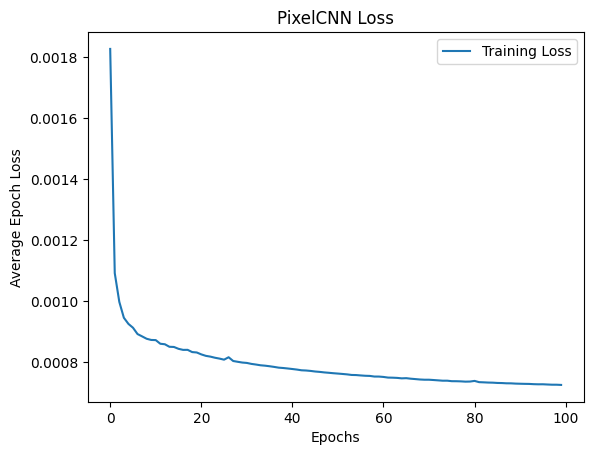

In [63]:
plt.plot(loss_history, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Average Epoch Loss")
plt.title("PixelCNN Loss")
plt.legend()

## Sampling

Sampling is done like so:
1. Start with an image of all zeros.
2. Iterate through all pixels, starting from the top-left corner:
    - Run PixelCNN to get a probability distribution of possible values.
    - Sample from this probability distribution to get a value for the current pixel.
    - Repeat until all pixels have been predicted.

In [66]:
# Takes as input a probability vector a length 4 and chooses a random number 
# from 0 to 3 based on that probability vector
def sample_from(probs, temperature):
    probs -= np.min(probs)
    probs = probs ** (1 / temperature)
    probs = probs / np.sum(probs)
    choice = np.random.choice(len(probs), p=probs)
    return torch.tensor(choice)

# Generate a single example, temperature controls how much randomness we want, 
# the lower the temperature the more consistent the results
def generate(temperature, label):
    # Start with an empty image
    num_img = 1
    generated_images = torch.zeros((num_img,1,28,28)).to(device)
    batch, channel, rows, cols = generated_images.shape

    # Predict 1 pixel at a time
    for row in range(rows):
        for col in range(cols):
            probs = pixel_cnn(generated_images, label)
            for b in range(num_img):
                generated_images[b,0,row,col] = sample_from(
                    probs[b,:,row,col].cpu().detach().numpy(),
                    temperature
                ) / 3

    return generated_images

Finally, we generate some example images.  For some variation we will try to generate images for digits 0, 1, 2, 3, and 4.

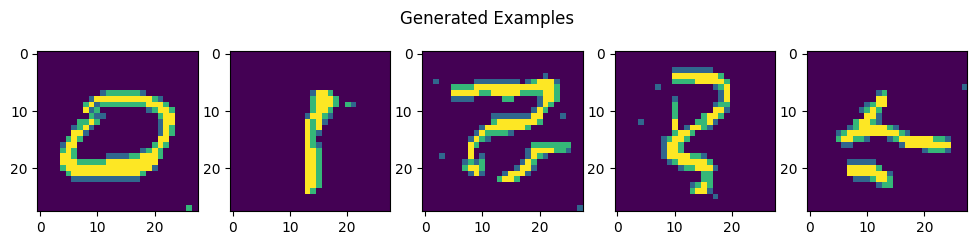

In [68]:
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('Generated Examples')
for idx in range(5):
    generated_image = generate(0.2, torch.tensor(idx).to(device))
    ax[idx].imshow(generated_image[0,0].cpu().detach().numpy())